In [1]:
import astropy.io.fits as fits
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp
from scipy import ndimage
import random
from scipy.optimize import leastsq
from scipy import ndimage
from scipy.optimize import least_squares
from func import *
from scipy import stats
from matplotlib.colors import LogNorm

In [2]:
hdu = fits.open('/Volumes/Seagate/HE0040-1105 Extended/HE0040-1105.extended_cube.fits')
qso_data = hdu[0].data
qso_error = hdu[1].data
qso_header = hdu[0].header
#print(qso_header)
wavestart = qso_header['CRVAL3']
wavint = qso_header['CD3_3']
wave = wavestart+np.arange(qso_data.shape[0])*wavint#. This is the same as the one below.
qso_data[np.isnan(qso_data)] = 0.0000001
qso_error[np.isnan(qso_error)] = 0.000001
(central_y,central_x) = ndimage.measurements.maximum_position(qso_data[212,:,:])
print (central_x,central_y)

49 50


In [3]:
def BIC(data,model,n_free_par):
    N = len(data)
    BIC=stats.chisquare(data,model)[0] +n_free_par*(np.log(N) - np.log(2*np.pi))
    return BIC

In [4]:
z =0.04196
k = 1+z
c = 300000
central_vel = c*z
mini_data = qso_data
mini_error = qso_error
 
par = np.zeros((10,mini_data.shape[1],mini_data.shape[2]),dtype=np.float32)
err = np.zeros((10,mini_data.shape[1],mini_data.shape[2]),dtype=np.float32)
fitted = np.zeros((np.shape(wave)[0],mini_data.shape[1],mini_data.shape[2]),dtype=np.float32)
residuals = np.zeros((np.shape(wave)[0],mini_data.shape[1],mini_data.shape[2]),dtype=np.float32)
 
select_cont = (wave > 5070*k) & (wave < 5090*k)
select_OIII = (wave > 4997*k) & (wave <5017*k)
select_Hb = (wave > 4851*k) & (wave <4871*k)

In [5]:
(xw,yw) = (65,57)
small_dat = qso_data[:,yw-2:yw+3,xw-2:xw+3]
small_err = qso_error[:,yw-2:yw+3,xw-2:xw+3]

In [6]:
c = 300000
z = 0.04196
(dat,err) = int_spec(small_dat,small_err)
central_vel = c*z

lower_bounds = [0,0,central_vel - 1000,0,0,0,central_vel - 1000,0,-np.inf,-np.inf]
upper_bounds = [np.inf,np.inf,central_vel + 1000,600,np.inf,np.inf,central_vel + 1000,600,np.inf,np.inf]
bounds_p_init = (lower_bounds,upper_bounds)

amp_OIII = np.max(dat[select_OIII])
amp_Hb = np.max(dat[select_Hb])   

x = wave
y = dat
y_err = err

In [7]:
result1 = least_squares(full_gauss_eline,bounds=bounds_p_init,x0=[amp_Hb,amp_OIII,central_vel,100,0.0,0.0,central_vel,0,0.0001,0.002],args = (x,y,y_err),max_nfev=10000000)
popt1 = result1['x']
model1 = full_gauss_eline(popt1,x,y,y_err)*(y_err)+y
BIC1 = BIC(y,model1,6)

result2 = least_squares(full_gauss2_eline,bounds=(lower_bounds,upper_bounds),x0=[0.7*amp_Hb,0.7*amp_OIII,central_vel,100,0.3*amp_Hb,0.3*amp_OIII,central_vel - 100,100,0.0001,0.002],args = (x,y,y_err),max_nfev=10000000)
popt2 = result2['x']
model2 = full_gauss2_eline(popt2,x,y,y_err)*(y_err)+y
BIC2 = BIC(y,model2,10)
            
if BIC2 - BIC1 > 10:
    popt = popt2
else:
    popt = popt1
    
print (popt)
model = full_gauss2_eline(popt,x,y,y_err)*(y_err)+y
core = Hb_O3_gauss(x,popt[0],popt[1],popt[2],popt[3]) + continuum(x,popt[8],popt[9])
wing = Hb_O3_gauss(x,popt[4],popt[5],popt[6],popt[7])+ continuum(x,popt[8],popt[9])

[ 1.81220186e-02  1.36753989e-01  1.24872633e+04  1.76359756e+02
  2.23802250e-02  3.64758661e-01  1.23464548e+04  1.65675784e-02
 -4.99846524e-03  3.07951872e-02]


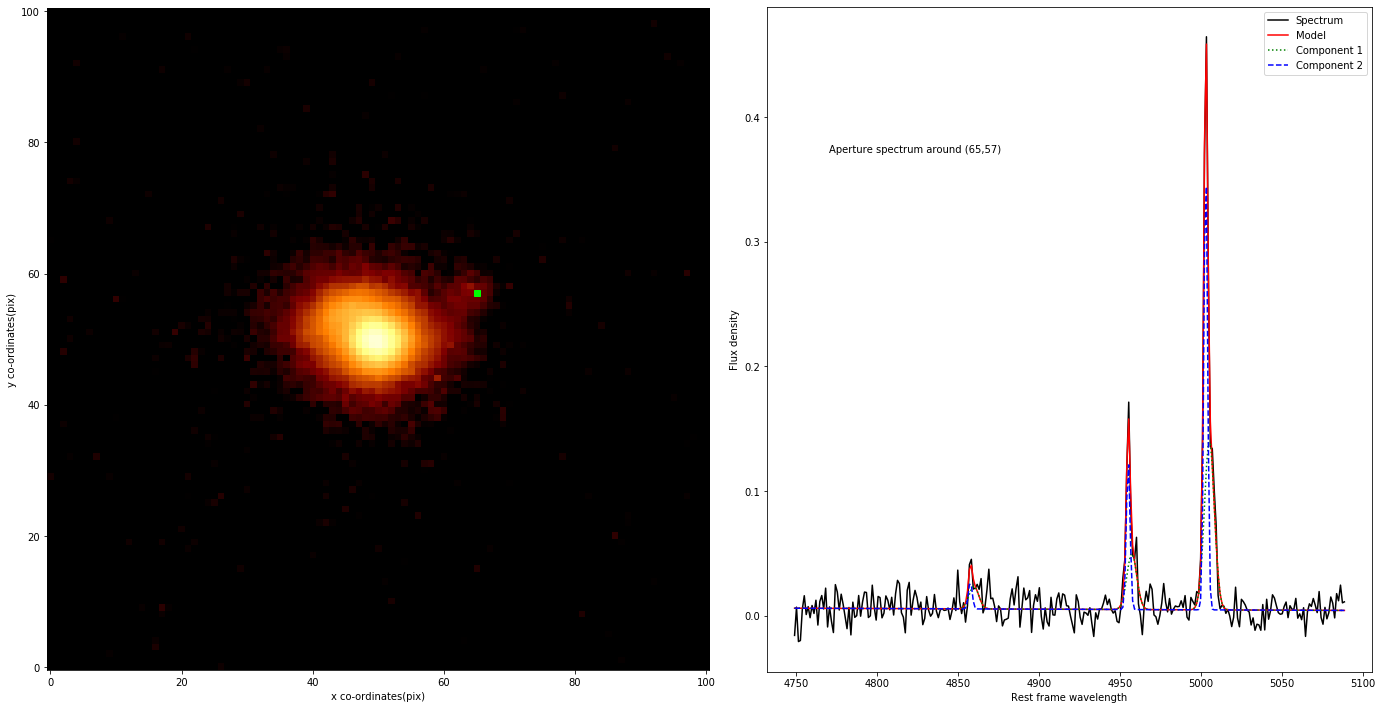

In [8]:
fig = plt.figure(figsize=(20,11))
ax1 = fig.add_axes([0.06, 0.1, 0.46, 0.84]) # main axes
ax2 = fig.add_axes([0.56, 0.1, 0.42, 0.84]) # main axes


pic_slice = qso_data[213,:,:]
pic_slice[pic_slice<1e-4] = 1e-15
ax1.imshow(pic_slice,origin='lower',interpolation='nearest',cmap='afmhot',norm=LogNorm(),vmin=0.003,vmax=3)
ax1.set_xlabel('x co-ordinates(pix)')
ax1.set_ylabel('y co-ordinates(pix)')

ax1.plot(xw,yw,'s',color='Lime')
ax2.plot(x/(1+z),dat,'k-',label='Spectrum')
ax2.plot(x/(1+z),model,'r-',label='Model')
ax2.plot(x/(1+z),core,'g:',label='Component 1')
ax2.plot(x/(1+z),wing,'b--',label='Component 2')
ax2.set_xlabel('Rest frame wavelength')
ax2.set_ylabel('Flux density')
ax2.text(4770,0.8*np.max(dat),'Aperture spectrum around (%s,%s)'%(xw,yw))
ax2.legend()
fig.savefig('/Volumes/Seagate/HE0040-1105 Extended/Coadded spectrum (5 pixels) around (%s,%s)'%(xw,yw),overwrite=True)